In [1]:
import string
import numpy as np
from PIL import Image
import os
from pickle import dump, load
import numpy as np
from keras.applications.xception import Xception, preprocess_input

from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import add
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout
import pickle
# small library for seeing the progress of loops.
from tqdm import tqdm_notebook as tqdm

tqdm().pandas()

C:\Users\hp\AppData\Local\Temp\ipykernel_17232\2422556632.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tqdm().pandas()


0it [00:00, ?it/s]

In [61]:
df_images = r"C:\Users\hp\Desktop\flickr30k_images\flickr30k_images"
# df_text = r"Flicker8k_text"
filename1 = r"C:\Users\hp\Desktop\flickr30k_images\train.txt"#run in start before text preprocessing
test = r"C:\Users\hp\Desktop\flickr30k_images\test.txt"

In [62]:
filename1

'C:\\Users\\hp\\Desktop\\flickr30k_images\\train.txt'

In [63]:
df_images

'C:\\Users\\hp\\Desktop\\flickr30k_images\\flickr30k_images'

In [81]:
def load_doc(filename):
    file = open(filename, 'r',encoding='utf8')
    text = file.read()
    file.close()
    return text

In [65]:
# def all_img_captions(filename):
#     file = load_doc(filename)
#     captions = file.split('\n')
#     print(captions[1])
#     descriptions ={}
#     #print(captions[1].split(',')[0])
#     for caption in captions[:-1]:
#         #print(caption)
#         img= caption.split('#')
#         caption=caption.split('#')[0]
#         #print(img[:-4],"  ",caption)
#         if img[:-2] not in descriptions:
#             descriptions[img[:-2]] = [ caption ]
#         else:
#             descriptions[img[:-2]].append(caption)
#     return descriptions
def all_img_captions(filename):
    file = load_doc(filename)
    captions = file.split('\n')
    descriptions = {}
    for caption in captions[:-1]:
        img_caption = caption.split('#')
        img = img_caption[0]
        caption = img_caption[1]
        if img not in descriptions:
            descriptions[img] = [caption]
        else:
            descriptions[img].append(caption)
    return descriptions

descriptions = all_img_captions(filename1)


In [66]:
descriptions=all_img_captions(filename1)


In [67]:
def cleaning_text(captions):
    table = str.maketrans('','',string.punctuation)
    #print(table)
    for img,caps in captions.items():
        for i,img_caption in enumerate(caps):
            img_caption.replace("-"," ")
            desc = img_caption.split()
            desc = [word.lower() for word in desc]
            desc = [word.translate(table) for word in desc]
            desc = [word for word in desc if(len(word)>1)]
            desc = [word for word in desc if(word.isalpha())]
            img_caption = ' '.join(desc)
            #print(captions)
            captions[img][i]= img_caption
    return captions


In [68]:
clean_descriptions = cleaning_text(descriptions)

In [69]:
clean_descriptions

{'1000092795.jpg': ['two young guys with shaggy hair look at their hands while hanging out in the yard',
  'two young white males are outside near many bushes',
  'two men in green shirts are standing in yard',
  'man in blue shirt standing in garden',
  'two friends enjoy time spent together'],
 '10002456.jpg': ['several men in hard hats are operating giant pulley system',
  'workers look down from up above on piece of equipment',
  'two men working on machine wearing hard hats',
  'four men on top of tall structure',
  'three men on large rig'],
 '1000268201.jpg': ['child in pink dress is climbing up set of stairs in an entry way',
  'little girl in pink dress going into wooden cabin',
  'little girl climbing the stairs to her playhouse',
  'little girl climbing into wooden playhouse',
  'girl going into wooden building'],
 '1000344755.jpg': ['someone in blue shirt and hat is standing on stair and leaning against window',
  'man in blue shirt is standing on ladder cleaning window',
 

In [70]:
def t_vocabulary(descriptions):
    vocab = set()
    for key in descriptions.keys():
        [vocab.update(d.split()) for d in descriptions[key]]
    return vocab

In [71]:
vocabulary=t_vocabulary(clean_descriptions)
print(len(vocabulary))

16281


In [72]:
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + '\t' + desc )
    data = "\n".join(lines)
    file = open(filename,"w")
    file.write(data)
    file.close()

In [73]:
save_descriptions(clean_descriptions, "descriptions_30k.txt")

In [15]:
# from keras.preprocessing import image
import keras.utils as image

In [16]:
for img_ in tqdm(os.listdir(df_images)):
    filename = df_images+ "/" + img_

print(filename)

C:\Users\hp\AppData\Local\Temp\ipykernel_17232\1417213886.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for img_ in tqdm(os.listdir(df_images)):


  0%|          | 0/31783 [00:00<?, ?it/s]

C:\Users\hp\Desktop\flickr30k_images\flickr30k_images/998845445.jpg


In [54]:

import imageio

# Load an image

# def extract_features(directory):
#         model = Xception( include_top=False, pooling='avg' )
#         features = {}
#         for img_ in tqdm(os.listdir(directory)):
#             filename = directory+ "/" + img_
#             print(filename)
#             # img = imageio.imread(filename)
#             img = Image.open(filename)
#             img = img.resize((299,299))
#             img = np.expand_dims(img, axis=0)
#             #image = preprocess_input(image)
#             img = img/127.5
#             img = img - 1.0
#             feature = model.predict(img)
#             features[img_] = feature
#         return filename

# def extract_features(directory):
#     # Get the paths to all the images in the directory
#     img_paths = [os.path.join(directory, fname) for fname in os.listdir(directory)]

#     # Initialize the Xception model
#     model = Xception(include_top=False, pooling='avg')

#     # Extract features for each image
#     features = {}
#     for img_path in tqdm(img_paths):
#         try:
#             img = load_img(img_path, target_size=(299, 299))
#             img = np.expand_dims(img, axis=0)
#             img = preprocess_input(img)
#             feature = model.predict(img).reshape(-1)
#             features[os.path.basename(img_path)] = feature
#         except Exception as e:
#             print(f"Error processing image: {img_path}. {str(e)}")

#     return features

In [36]:
import keras_preprocessing.image as image

In [117]:
# load vgg16 model
model = Xception()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

91884032/91884032 [==============================] - 8s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                      

In [122]:
from keras_preprocessing.image import load_img, img_to_array
features = {}
directory = os.path.join(df_images)

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(299, 299))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for xception
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

C:\Users\hp\AppData\Local\Temp\ipykernel_17232\1648042234.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for img_name in tqdm(os.listdir(directory)):


  0%|          | 0/31783 [00:00<?, ?it/s]

In [123]:
dump(features, open('features_xception_30k.pkl', 'wb'))

In [17]:
features = load(open(r"C:\Users\hp\Desktop\Random_Programs\Python\projects\venv\Actual_projects\Image_Caption_Generator\features_xception_30k.pkl","rb"))

In [82]:
def load_doc_1(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

In [85]:
def load_photos(filename):
    file = load_doc(filename) 
    images = file.split("\n")[:-1]
    return images

In [86]:
train_images=load_photos(filename1)


In [93]:
captions_doc = load_doc('descriptions_30k.txt')

In [99]:
# def load_clean(filename, images): 
#     file = load_doc_1(filename)
#     descriptions = {}
#     for line in file.split("\n"):
#         words = line.split()
#         #print(words)
#         if len(words)<1 :
#             continue
#         image, image_caption = words[0], words[1:]
#         # print(image," ",image_caption)
#         if image in images:
#             print(descriptions)
#             if image not in descriptions:
#                 descriptions[image] = list()
#             desc = '<start> ' + " ".join(image_caption) + ' <end>'
#             descriptions[image].append(desc)
#             # print(desc)
#     return descriptions




# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(' ')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)



def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption



C:\Users\hp\AppData\Local\Temp\ipykernel_17232\2293747363.py:45: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for line in tqdm(captions_doc.split('\n')):


  0%|          | 0/108914 [00:00<?, ?it/s]

In [103]:

# preprocess the text
clean(mapping)

In [104]:
mapping['1000366164']

['startseq men one in gray shirt one in black shirt standing near stove endseq',
 'startseq guy cooking and joking around with the camera endseq',
 'startseq men in kitchen cooking food on stove endseq',
 'startseq men are at the stove preparing food endseq',
 'startseq men are cooking meal endseq']

In [105]:
# train_desc=clean("descriptions_30k.txt", train_images)

all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

len(all_captions)


108914

In [106]:
all_captions[:10]

['startseq young guys with shaggy hair look at their hands while hanging out in the yard endseq',
 'startseq young white males are outside near many bushes endseq',
 'startseq men in green shirts are standing in yard endseq',
 'startseq in blue shirt standing in garden endseq',
 'startseq friends enjoy time spent together endseq',
 'startseq men in hard hats are operating giant pulley system endseq',
 'startseq look down from up above on piece of equipment endseq',
 'startseq men working on machine wearing hard hats endseq',
 'startseq men on top of tall structure endseq',
 'startseq men on large rig endseq']

In [107]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
dump(tokenizer, open('tokenizer30k.p', 'wb'))
vocab_size = len(tokenizer.word_index) + 1

In [108]:
vocab_size

15877

In [109]:
#  get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

73

In [110]:
def load_features(images):
    features = load(open(r"C:\Users\hp\Desktop\Random_Programs\Python\projects\venv\Actual_projects\Image_Caption_Generator\features_xception_30k.pkl","rb"))
    selected_features = {i:features[i] for i in images}
    return selected_features

In [124]:
# load features from pickle
with open(os.path.join('features_xception_30k.pkl'), 'rb') as f:
    features = pickle.load(f)

In [125]:
print(features)

{'1000092795': array([[0.10315504, 0.03061771, 0.01948451, ..., 0.02074278, 0.        ,
        0.18524022]], dtype=float32), '10002456': array([[0.29922843, 0.37628484, 0.13982761, ..., 0.07507584, 0.5120121 ,
        0.0158221 ]], dtype=float32), '1000268201': array([[0.3593294 , 0.03258388, 0.03683675, ..., 0.1382578 , 0.02852332,
        0.3069763 ]], dtype=float32), '1000344755': array([[0.17265438, 0.11268887, 0.00069092, ..., 0.12517788, 0.        ,
        0.        ]], dtype=float32), '1000366164': array([[0.01108751, 0.        , 0.11267254, ..., 0.010824  , 0.21049385,
        0.        ]], dtype=float32), '1000523639': array([[0.        , 0.3039631 , 0.01751634, ..., 0.07902184, 0.01950656,
        0.59283125]], dtype=float32), '1000919630': array([[0.16675752, 0.063289  , 0.02142417, ..., 0.17968561, 0.01542746,
        0.23908404]], dtype=float32), '10010052': array([[0.01171933, 0.6295787 , 0.        , ..., 0.01763361, 0.        ,
        0.0107819 ]], dtype=float32), '10

In [64]:
#tokenizing

In [65]:
# from keras.preprocessing.text import Tokenizer
# def create_tokenizer(descriptions):
#     all_desc = []
#     for key in descriptions.keys():
#         [all_desc.append(d) for d in descriptions[key]]
#     tokenizer = Tokenizer()
#     tokenizer.fit_on_texts(all_desc)
#     return tokenizer

In [66]:
# tokenizer = create_tokenizer(train_desc)
# dump(tokenizer, open('tokenizer.p', 'wb'))
# vocab_size = len(tokenizer.word_index) + 1
# vocab_size

7577

In [67]:
# def max_length(descriptions):
#     all_desc = []
#     for key in descriptions.keys():
#         [all_desc.append(d) for d in descriptions[key]]
#     return max(len(d.split()) for d in all_desc)
    
# max_lengths = max_length(descriptions)
# max_lengths

32

In [128]:
# def data_generator(descriptions, features, tokenizer, max_length, vocab_size):
    
#     while 1:
#         for key, description_list in descriptions.items():
#             #retrieve photo features
#             feature = features[key][0]
#             input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
#             yield [[input_image, input_sequence], output_word]
# def create_sequences(tokenizer, max_length, desc_list, feature):
#     X1, X2, y = list(), list(), list()
#     # walk through each description for the image
#     for desc in desc_list:
#         # encode the sequence
#         seq = tokenizer.texts_to_sequences([desc])[0]
#         # split one sequence into multiple X,y pairs
#         for i in range(1, len(seq)):
#             # split into input and output pair
#             in_seq, out_seq = seq[:i], seq[i]
#             # pad input sequence
#             in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
#             # encode output sequence
#             out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
#             # store
#             X1.append(feature)
#             X2.append(in_seq)
#             y.append(out_seq)
#             #print(np.array(X1))
#     return np.array(X1), np.array(X2), np.array(y)


image_ids = list(mapping.keys())
train = image_ids 
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

In [129]:
epochs = 20
batch_size = 32

In [130]:
[a,b],c=next(data_generator(train,mapping, features, tokenizer, max_length,vocab_size, batch_size))

In [131]:
a.shape

(1618, 2048)

In [134]:
from keras.layers import GRU

In [135]:
# define the captioning model
from keras.utils import plot_model
from keras.optimizers import Adam
def define_model(vocab_size, max_length, learning_rate = 0.001):
    
    # features from the CNN model squeezed from 2048 to 256 nodes
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.4)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    
    
    # gru sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.4)(se1)
    se3 = GRU(units=256)(se2)
    
    
    # Merging both models
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    optimizer = Adam(lr=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics= ['accuracy'])
 

    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 73)]         0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 73, 256)      4064512     ['input_5[0][0]']                
                                                                                                  
 dropout_2 (Dropout)            (None, 2048)         0           ['input_4[0][0]']                
                                                                                            

c:\Users\hp\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
C:\Users\hp\AppData\Local\Temp\ipykernel_17232\3447148881.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(generator, epochs=1, steps_per_epoch=steps,verbose=1)


680/680 [==============================] - 209s 308ms/step - loss: 2.6267 - accuracy: 0.3946


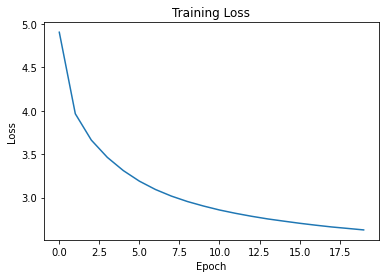

In [136]:
# train the model, run epochs manually and save after each epoch
import matplotlib.pyplot as plt
epochs = 20
steps = len(train) // batch_size
model=define_model(vocab_size,max_length)
train_loss = []
train_accuracy = []
os.mkdir('models_xception_30k')
for i in range(epochs):
 # create the data generator
    generator = data_generator(train,mapping, features, tokenizer, max_length,vocab_size, batch_size)
 # fit for one epoch
    history=model.fit_generator(generator, epochs=1, steps_per_epoch=steps,verbose=1)
    train_loss += history.history['loss']
    train_accuracy += history.history['accuracy']
    model.save('models_xception_30k/model_' + str(i) + '.h5')

# plot the training loss
plt.plot(train_loss)
plt.title('Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.savefig('train_loss.png')

In [137]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [138]:


# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text



In [142]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(r"C:\Users\hp\Desktop\flickr30k_images\flickr30k_images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)



---------------------Actual---------------------
startseq of men are sitting around table that has bottles of beer on it endseq
startseq of men sit around table laden with drinks and beer bottles endseq
startseq of guys gathered and drinking at bar endseq
startseq of men are at bar having drinks endseq
startseq of men is drinking at table endseq
--------------------Predicted--------------------
startseq of people are sitting around table drinking beer endseq


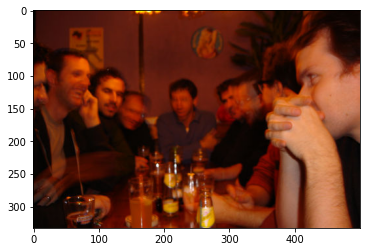

In [144]:
generate_caption("1440465.jpg")

In [148]:
img_path = os.path.join(r"C:\Users\hp\Desktop\flickr30k_images\flickr30k_images", r'C:\Users\hp\Desktop\x.jpg')
image = Image.open(img_path)
y_pred = predict_caption(model, features, tokenizer, max_length)
print('--------------------Predicted--------------------')
print(y_pred)
plt.imshow(image)

KeyboardInterrupt: 